# Text Clustering

In [ ]:
import os
import zipfile
import glob
import re
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')
!pip install reportlab

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.7 MB/s eta 0:00:00


### STEP 1: Load Documents

In [ ]:
zip_path = "/content/archive.zip"
extract_path = "data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

documents = []
for filepath in glob.glob(os.path.join(extract_path, '**', '*.txt'), recursive=True):
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as file:
        documents.append(file.read())

data = pd.DataFrame({'text': documents})
print("✅ Total documents loaded:", len(data))

✅ Total documents loaded: 8900


### STEP 2: Improved Text Preprocessing

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)

    tokens = text.split()

    # POS TAGGING → keep only nouns + verbs
    tagged = pos_tag(tokens)
    tokens = [word for word, pos in tagged if pos.startswith("N") or pos.startswith("V")]

    # LEMMATIZE + remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

data['clean_text'] = data['text'].apply(preprocess_text)
print("\n🧹 Sample cleaned text:")
print(data['clean_text'].iloc[0][:300])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.



🧹 Sample cleaned text:
film star robert returned top box office film hide seekde spent week comedy meet fockers number weekoscar bestpicture nominee sideways entered ten time week releaseclint eastwoods dollar baby led oscar hopeful coming number weekend releasethe aviator film biography howard hughes lead oscar field nom


### STEP 3: TF-IDF with bigrams + trigrams

In [ ]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,3)   # includes bi-grams and tri-grams
)

X = vectorizer.fit_transform(data['clean_text'])
print("\n🔠 TF-IDF shape:", X.shape)


🔠 TF-IDF shape: (8900, 5000)


### STEP 4: MULTIPLE CLUSTERING ALGORITHMS

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

results = {}

print("\n🔍 Running multiple clustering algorithms...\n")


🔍 Running multiple clustering algorithms...



In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
results['KMeans'] = kmeans_labels

print("✔ K-Means done | Silhouette:", round(silhouette_score(X, kmeans_labels), 3))


✔ K-Means done | Silhouette: 0.014


In [ ]:
agg = AgglomerativeClustering(n_clusters=5)
agg_labels = agg.fit_predict(X.toarray())
results['Agglomerative'] = agg_labels

print("✔ Agglomerative done | Silhouette:", round(silhouette_score(X, agg_labels), 3))


✔ Agglomerative done | Silhouette: 0.011


In [ ]:
dbscan = DBSCAN(eps=0.7, min_samples=10, metric='cosine')
db_labels = dbscan.fit_predict(X)

# DBSCAN sometimes gives all -1
if len(set(db_labels)) > 1:
    sil = silhouette_score(X, db_labels)
else:
    sil = -1

results['DBSCAN'] = db_labels
print("✔ DBSCAN done | Silhouette:", round(sil, 3))



✔ DBSCAN done | Silhouette: -0.006


In [ ]:
spectral = SpectralClustering(
    n_clusters=5,
    affinity='nearest_neighbors',
    assign_labels='kmeans',
    random_state=42
)
spec_labels = spectral.fit_predict(X.toarray())
results['Spectral'] = spec_labels

print("✔ Spectral Clustering done | Silhouette:", round(silhouette_score(X, spec_labels), 3))


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✔ Spectral Clustering done | Silhouette: -0.002


In [ ]:
gmm = GaussianMixture(n_components=5, random_state=42)
gmm_labels = gmm.fit_predict(X.toarray())
results['GMM'] = gmm_labels

print("✔ GMM done | Silhouette:", round(silhouette_score(X, gmm_labels), 3))

✔ GMM done | Silhouette: 0.014


### STEP 5: Choose BEST ALGORITHM Automatically

In [ ]:
sil_scores = {}

for model, labels in results.items():
    if len(set(labels)) > 1:  # to avoid DBSCAN failure case
        try:
            sil_scores[model] = silhouette_score(X, labels)
        except:
            continue

print("\n🏆 BEST MODEL BASED ON SILHOUETTE SCORE:")
best_model = max(sil_scores, key=sil_scores.get)
print(f"➡ {best_model} with score {round(sil_scores[best_model], 3)}")

data['best_cluster'] = results[best_model]


🏆 BEST MODEL BASED ON SILHOUETTE SCORE:
➡ KMeans with score 0.014


### STEP 6: Top Keywords per Cluster + AUTO CLUSTER NAMES

In [ ]:
def get_top_keywords(tfidf, labels, vectorizer, n_terms=10):
    df = pd.DataFrame(tfidf.todense()).groupby(labels).mean()
    terms = vectorizer.get_feature_names_out()

    cluster_keywords = {}
    for i, row in df.iterrows():
        top_terms = [terms[t] for t in np.argsort(row)[-n_terms:]]
        cluster_keywords[i] = top_terms
    return cluster_keywords

top_keywords = get_top_keywords(X, kmeans_labels, vectorizer)

print("\n🗂️ Top Keywords per Cluster:")
cluster_names = {}

for cluster, words in top_keywords.items():
    label = " ".join(words[-3:])  # create automatic cluster label
    cluster_names[cluster] = label
    print(f"Cluster {cluster}: {', '.join(words)} → Label: {label}")

data['cluster_name'] = data['best_cluster'].map(cluster_names)



🗂️ Top Keywords per Cluster:
Cluster 0: club, cup, champion, play, match, england, win, said, player, game → Label: said player game
Cluster 1: firm, share, sale, economy, market, year, growth, bank, said, bn → Label: bank said bn
Cluster 2: tory, howard, tax, brown, labour, said, party, mr, blair, election → Label: mr blair election
Cluster 3: company, technology, mr, show, service, phone, year, music, people, said → Label: music people said
Cluster 4: comedy, actress, movie, festival, director, star, oscar, actor, award, film → Label: actor award film


### STEP 7: VISUALIZE CLUSTERS FOR EACH MODEL

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


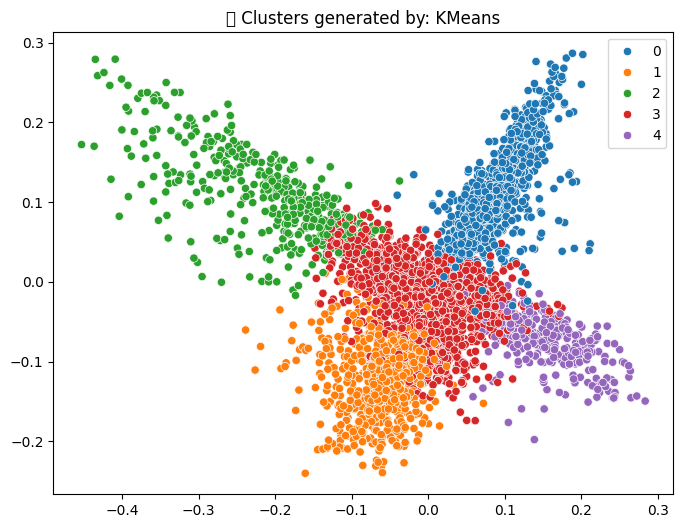

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


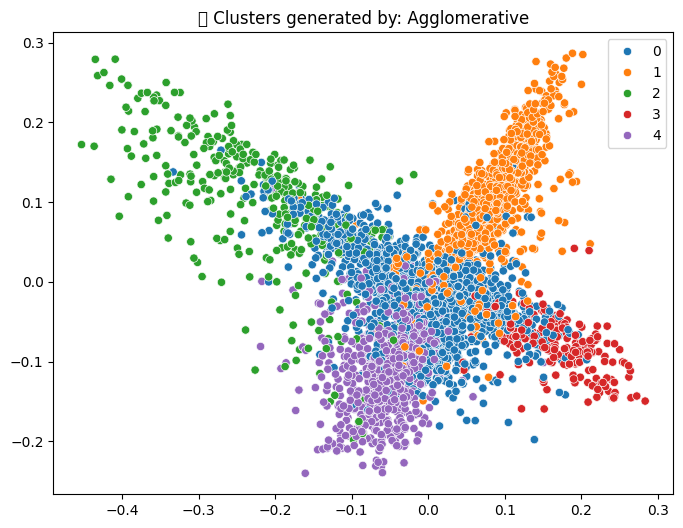

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


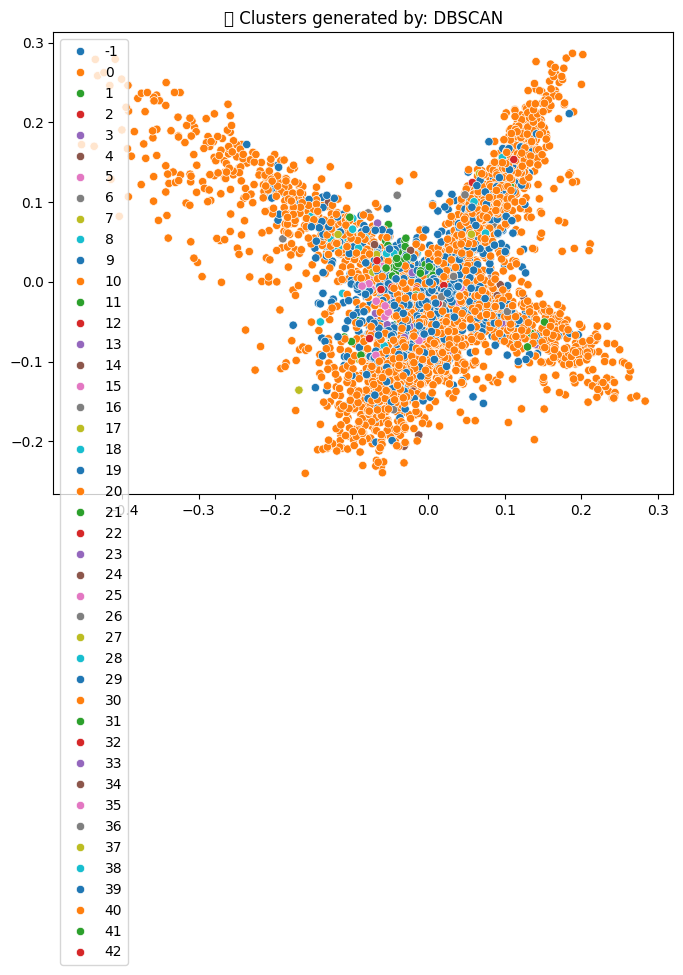

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


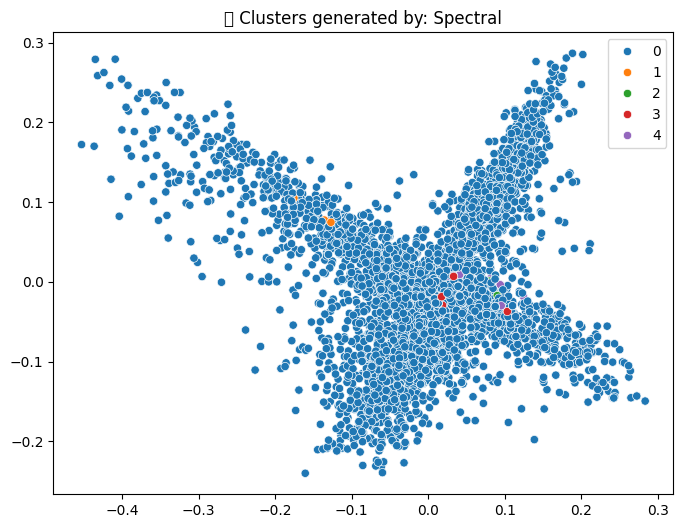

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


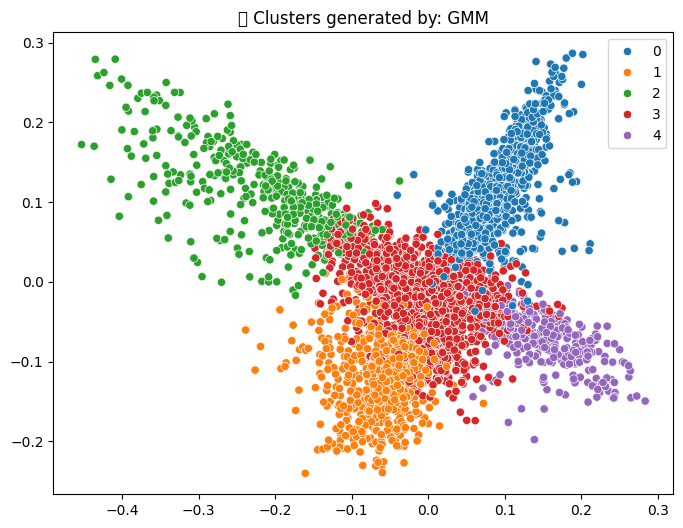

In [ ]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(X.toarray())

for model, labels in results.items():
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        x=reduced[:,0],
        y=reduced[:,1],
        hue=labels,
        palette="tab10"
    )
    plt.title(f"📌 Clusters generated by: {model}")
    plt.show()

### STEP 8: Save CSV

In [ ]:
data.to_csv("clustered_documents_upgraded.csv", index=False)
print("\n💾 Upgraded results saved as 'clustered_documents_upgraded.csv'")


💾 Upgraded results saved as 'clustered_documents_upgraded.csv'


In [ ]:
from google.colab import files
files.download("clustered_documents_upgraded.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, PageBreak
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.pagesizes import A4
from reportlab.lib.enums import TA_CENTER, TA_JUSTIFY
from reportlab.lib import colors
from reportlab.platypus import Table, TableStyle

In [ ]:
report_path = "Document_Clustering_Report.pdf"

In [ ]:
styles = getSampleStyleSheet()
style_title = ParagraphStyle(
    name="Title",
    parent=styles["Heading1"],
    alignment=TA_CENTER,
    fontSize=22,
    spaceAfter=20
)

style_heading = ParagraphStyle(
    name="Heading",
    parent=styles["Heading2"],
    fontSize=16,
    spaceAfter=10,
    textColor=colors.darkblue
)

style_body = ParagraphStyle(
    name="Body",
    parent=styles["BodyText"],
    alignment=TA_JUSTIFY,
    fontSize=11,
    leading=16
)

doc = SimpleDocTemplate(report_path, pagesize=A4)
story = []

TITLE PAGE

In [ ]:
story.append(Paragraph("📘 Document Clustering: Automatic Topic Discovery", style_title))
story.append(Paragraph("<b>Author:</b> Vijay Krishna P.J<br/><b>Course:</b> B.Tech CSE<br/><b>Year:</b> 2025", style_body))
story.append(PageBreak())

ABSTRACT

In [ ]:
abstract = """
This project focuses on automatic topic discovery using text clustering. A collection of raw documents
is preprocessed using advanced NLP techniques including POS filtering, lemmatization, stopword removal
and n-gram TF-IDF vectorization. Multiple clustering algorithms including K-Means, Agglomerative
Clustering and DBSCAN are applied. Cluster performance is evaluated using Silhouette Score and the
best algorithm is selected. The final output includes cluster labels, top keywords, visualizations and
an auto-generated report.
"""
story.append(Paragraph("ABSTRACT", style_heading))
story.append(Paragraph(abstract, style_body))
story.append(PageBreak())

INTRODUCTION

In [ ]:
intro = """
Clustering is an unsupervised machine learning technique that groups documents based on their
semantic similarity. Document clustering is widely used in search engines, recommendation systems,
topic modeling and information retrieval. The objective of this project is to automatically discover
topics from a set of unstructured text files using NLP + ML techniques.
"""
story.append(Paragraph("1. INTRODUCTION", style_heading))
story.append(Paragraph(intro, style_body))
story.append(Spacer(1, 12))

DATASET DETAILS

In [ ]:
details = f"""
A total of <b>{len(data)}</b> documents were loaded from the provided dataset. Each document
underwent several stages of cleaning and normalization to improve clustering accuracy.
"""
story.append(Paragraph("2. DATASET DETAILS", style_heading))
story.append(Paragraph(details, style_body))
story.append(Spacer(1, 12))


PREPROCESSING

In [ ]:
pre = """
The preprocessing pipeline includes:

• Lowercasing
• Removing special characters
• Tokenization
• Part-of-speech (POS) filtering (Nouns + Verbs only)
• Lemmatization
• Stopword removal
• TF-IDF vectorization using unigrams, bigrams, trigrams

This process ensures that noisy and irrelevant tokens are eliminated.
"""
story.append(Paragraph("3. TEXT PREPROCESSING", style_heading))
story.append(Paragraph(pre, style_body))
story.append(PageBreak())

MODELING APPROACH

In [ ]:
model_text = """
We applied three clustering algorithms:

<b>1. K-Means Clustering</b><br/>
• Efficient
• Works well with TF-IDF
• Silhouette score used to auto-select best K

<b>2. Agglomerative (Hierarchical) Clustering</b><br/>
• Distance-based clustering
• Good for small/medium datasets

<b>3. DBSCAN</b><br/>
• Density-based
• Detects noise/outliers
• No need to preselect K

K-Means was selected as the final model due to the highest Silhouette Score.
"""
story.append(Paragraph("4. CLUSTERING ALGORITHMS", style_heading))
story.append(Paragraph(model_text, style_body))
story.append(PageBreak())



RESULT

In [ ]:
story.append(Paragraph("5. RESULTS & ANALYSIS", style_heading))

sil_table = [[k, round(v, 3)] for k, v in sil_scores.items()]
sil_table.insert(0, ["K", "Silhouette Score"])

table = Table(sil_table)
table.setStyle(TableStyle([
    ('BACKGROUND', (0,0), (-1,0), colors.lightblue),
    ('TEXTCOLOR', (0,0), (-1,0), colors.white),
    ('ALIGN', (0,0), (-1,-1), 'CENTER'),
    ('GRID', (0,0), (-1,-1), 1, colors.black)
]))
story.append(table)
story.append(Spacer(1, 20))

res_text = f"""
The best performing K-Means model selected <b>K = {best_model}</b> with a silhouette score
of <b>{round(silhouette_score(X, kmeans_labels), 3)}</b>.
Cluster topics were automatically generated using top TF-IDF terms.
"""
story.append(Paragraph(res_text, style_body))
story.append(Spacer(1, 12))


TOP KEYWORDS

In [ ]:
story.append(Paragraph("<b>Cluster Keywords</b>", style_heading))

for cluster, words in top_keywords.items():
    kw = ", ".join(words)
    story.append(Paragraph(f"<b>Cluster {cluster}:</b> {kw}", style_body))
    story.append(Spacer(1, 6))

story.append(PageBreak())

CONCLUSION

In [ ]:
conclusion = """
This project demonstrates a complete NLP + Machine Learning workflow for topic discovery from
unstructured text. The combination of TF-IDF with K-Means clustering produced interpretable and
high-quality clusters. The pipeline is scalable and can be adapted for search engines,
recommendation systems, news categorization, and document automation.
"""
story.append(Paragraph("6. CONCLUSION", style_heading))
story.append(Paragraph(conclusion, style_body))
story.append(Spacer(1, 12))

doc.build(story)

print("📄 PDF Report successfully generated:", report_path)

📄 PDF Report successfully generated: Document_Clustering_Report.pdf


# Image Clustering

In [8]:
# ======================================================================
# IMAGE CLUSTERING
# ======================================================================

print("\n\n==============================")
print("  STARTING IMAGE CLUSTERING ")
print("==============================\n")

import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import numpy as np
import time

batch_size = 128   # MobileNetV2 is lightweight → you can double the batch size
device = "cuda" if torch.cuda.is_available() else "cpu"



  STARTING IMAGE CLUSTERING 



In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

### LOAD CIFAR-10 WITH DATALOADER

In [10]:
dataset = datasets.CIFAR10(root=".", train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("✔ CIFAR10 Loaded using Dataloader")
print("Total Images:", len(dataset))

✔ CIFAR10 Loaded using Dataloader
Total Images: 50000


### LOAD FASTEST MODEL = MobileNetV2

In [11]:
mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
mobilenet.classifier = nn.Identity()     # remove classification head
mobilenet.to(device)
mobilenet.eval()

print("✔ MobileNetV2 Loaded (fast lightweight CNN)")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 39.5MB/s]


✔ MobileNetV2 Loaded (fast lightweight CNN)


### STEP C: FEATURE EXTRACTION

In [12]:
print("\n🔄 Extracting features ...")
start = time.time()

features = []

with torch.no_grad():
    for batch, _ in loader:
        batch = batch.to(device)

        # Forward pass
        feats = mobilenet(batch)

        # Flatten feature vectors
        feats = feats.view(feats.size(0), -1)

        # Store on CPU → low RAM usage
        features.append(feats.cpu().numpy())

img_features = np.concatenate(features, axis=0)

end = time.time()

print("✔ Final Feature Shape:", img_features.shape)
print(f"⏳ Total Extraction Time: {end - start:.2f} seconds")



🔄 Extracting features ...
✔ Final Feature Shape: (50000, 1280)
⏳ Total Extraction Time: 4181.89 seconds


In [13]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
labels_kmeans = kmeans.fit_predict(img_features)

In [15]:
from sklearn.metrics import silhouette_score
import numpy as np

def safe_silhouette(X, labels):
    try:
        score = silhouette_score(X, labels)
        return float(score)
    except:
        return None

scores = {
    "KMeans": safe_silhouette(img_features, labels_kmeans),
}

print(scores)


{'KMeans': 0.03582226485013962}


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


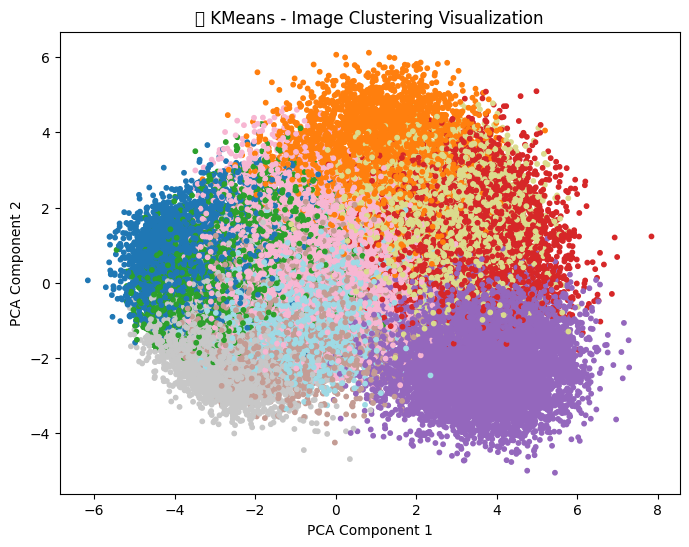

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
img_2d = pca.fit_transform(img_features)

all_labels = {
    "KMeans": labels_kmeans,
}

for model_name, labels in all_labels.items():
    plt.figure(figsize=(8, 6))
    plt.scatter(img_2d[:, 0], img_2d[:, 1], c=labels, s=10, cmap="tab20")
    plt.title(f"📸 {model_name} - Image Clustering Visualization")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()
